In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt

N = 64

def WaveEq():
    u = tf.input([N, N], tf.float32)
    v = tf.input([N, N], tf.float32)

    i,j = u.indices

    laplacian = u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - u * 4.0 - 0.5 * tf.sin(2.0*np.pi*u)

    print("hello")

    dt = 0.2
    v_new = v + dt*laplacian
    u_new = u + dt*v_new

    return [u_new, v_new]

tf.initialize(tf.cpu, "H:/tinycc/win32/tcc.exe")
test = tf.program(WaveEq)
#test.list_operations(compact=True)
#test.kernel_c()


TensorFrost module loaded!
dim =  2
hello


In [2]:
#intialize as a gaussian pulse in the middle
Anp = np.zeros((N, N))
Bnp = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        Anp[i, j] = np.exp(-((i-N/3)**2 + (j-N/3)**2)/10)

A = tf.memory(Anp)
B = tf.memory(Bnp)
C = test(A, B)

print("Used memory: " + str(tf.used_memory()))

Used memory: 16384


In [3]:
#do a few steps and measure performance by timing every 100 steps
import time
start = time.time()

for i in range(200):
    C = test(C[1], C[0])
    if i % 100 == 0:
        print("Used memory: " + str(tf.used_memory()))
        print("Time: " + str(time.time() - start))
        start = time.time()

Used memory: 24576
Time: 0.000997304916381836
Used memory: 843776
Time: 0.05999946594238281


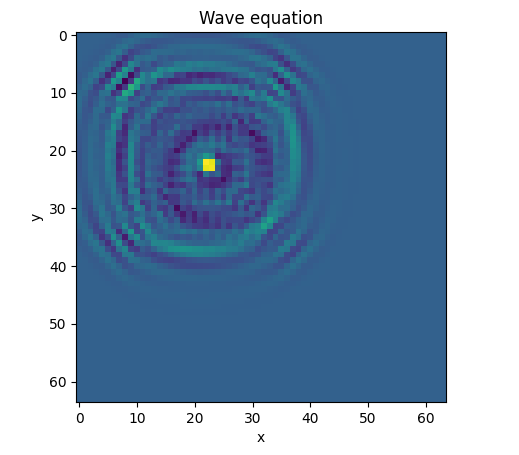

In [8]:
# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(C[0].numpy)
ax.set_title('Wave equation')
ax.set_xlabel('x')
ax.set_ylabel('y')
#set colorbar
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.show()
